In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [43]:
path = 'data/Conventional'                     
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
conventional_df = pd.concat(df_from_each_file, ignore_index=True)

In [44]:
conventional_df['Date'] = pd.to_datetime(conventional_df['Date'])
conventional_df.set_index('Date', inplace=True)

In [45]:
conventional_df = conventional_df.sort_index()

In [46]:
conventional_df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

In [47]:
path = 'data/Organic'                     
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
organic_df = pd.concat(df_from_each_file, ignore_index=True)

In [48]:
organic_df['Date'] = pd.to_datetime(organic_df['Date'])
organic_df.set_index('Date', inplace=True)

In [49]:
organic_df = organic_df.sort_index()
print(organic_df)

            AveragePrice  Total Volume       4046       4225      4770  \
Date                                                                     
2016-01-03          1.43     704100.50  124799.63  246580.95   7749.40   
2016-01-10          1.35     828670.59  113867.63  287590.19   8771.79   
2016-01-17          1.44     695341.42  115992.81  266824.72  13106.29   
2016-01-24          1.41     776964.55   99316.69  270980.88  12933.97   
2016-01-31          1.43     772077.20  108929.21  269687.52   5515.91   
2016-02-07          1.44     758795.10  101408.79  290813.54   8028.75   
2016-02-14          1.37     852463.31  102897.63  306235.69   6955.69   
2016-02-21          1.45     738856.92  104135.94  281188.89   8629.03   
2016-02-28          1.44     845011.63  110120.49  347488.78  10423.30   
2016-03-06          1.28    1012415.85  127184.88  351951.65   5698.20   
2016-03-13          1.29    1023655.87  132040.04  346341.46   6709.65   
2016-03-20          1.27    1045450.41

In [50]:
organic_df.isnull().sum()

AveragePrice    1
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

In [51]:
organic_df.fillna(organic_df.mean(),inplace=True)

In [52]:
organic_df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

In [55]:
print(organic_df)

            AveragePrice  Total Volume       4046       4225      4770  \
Date                                                                     
2016-01-03         1.430     704100.50  124799.63  246580.95   7749.40   
2016-01-10         1.350     828670.59  113867.63  287590.19   8771.79   
2016-01-17         1.440     695341.42  115992.81  266824.72  13106.29   
2016-01-24         1.410     776964.55   99316.69  270980.88  12933.97   
2016-01-31         1.430     772077.20  108929.21  269687.52   5515.91   
2016-02-07         1.440     758795.10  101408.79  290813.54   8028.75   
2016-02-14         1.370     852463.31  102897.63  306235.69   6955.69   
2016-02-21         1.450     738856.92  104135.94  281188.89   8629.03   
2016-02-28         1.440     845011.63  110120.49  347488.78  10423.30   
2016-03-06         1.280    1012415.85  127184.88  351951.65   5698.20   
2016-03-13         1.290    1023655.87  132040.04  346341.46   6709.65   
2016-03-20         1.270    1045450.41

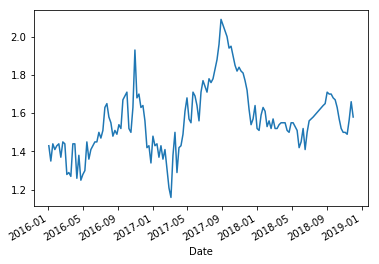

In [56]:
organic_df['AveragePrice'].plot()